# Notebook to merge and visualize data from different devices

Valentina's work on the IDEA-FAST hackathon of November 5-6 2020
valentina.ticcinelli@ucb.com

Please create an output folder, containing the subfolders:
  * output_AX6, with file Day2.csv
  * output_VP_features, with files VitalPatch_:  ECGQuality, ...ECGTime, ...HeartRate, ...RRIntervals

In [1]:
# Importing Libraries
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import plotly.graph_objects as go
from datetime import datetime
from plotly.subplots import make_subplots


## Upload the AX6 dataset
(output from Axivity's code)

In [2]:
dfACC = pd.read_csv('../output/output_AX6/Day2.csv')#, header=None

print(np.shape(dfACC))
dfACC.columns = ['Time', 'X','Y','Z','Xg','Yg','Zg']
#compute total ACC
dfACC['Tot Acc']=np.sqrt(dfACC['X']*dfACC['X']+dfACC['Y']*dfACC['Y']+dfACC['Z']*dfACC['Z'])
dfACC.head()

(8753800, 7)


Time         X         Y         Z        Xg        Yg        Zg  \
0  738038.00069  0.985352  0.067383  0.019043 -0.061035  0.366211 -0.427246   
1  738038.00069  0.982910  0.066895  0.017578  0.000000  0.366211 -0.427246   
2  738038.00069  0.985840  0.067383  0.017578  0.061035  0.305176 -0.488281   
3  738038.00069  0.984863  0.067871  0.017578  0.000000  0.305176 -0.488281   
4  738038.00069  0.987305  0.068848  0.017090  0.000000  0.366211 -0.610352   

    Tot Acc  
0  0.987836  
1  0.985341  
2  0.988296  
3  0.987356  
4  0.989850

### Fix the timestamps:
    
This needs to be checked: the timestamps seem to be in a non-unix time: this setting has to be selected from the AX6 interface when the recording is planned, and choose the right option (also, the output format of the raw data can be set as csv there)

In [3]:
dt_obj = datetime.strptime('03.09.2020 02:00:00,00',  #date of interest for start
                           '%d.%m.%Y %H:%M:%S,%f')
Fs=100                                                #sample frequency
millisec_start = round(dt_obj.timestamp() * 1000)    
sampl_num=np.shape(dfACC)[0]
length_millis=round(sampl_num*1000/Fs)
time_millis= np.arange(start=millisec_start, stop=millisec_start+length_millis, step=1000/Fs) #time axis in millisecond from start to start+signal lenght
dfACC['Time'] = pd.to_datetime(time_millis,unit='ms')                                    #convert to date
print('shape of dfAcc: ',  np.shape(dfACC))
dfACC.head()

shape of dfAcc:  (8753800, 8)


Time         X         Y         Z        Xg        Yg  \
0 2020-09-03 00:00:00.000  0.985352  0.067383  0.019043 -0.061035  0.366211   
1 2020-09-03 00:00:00.010  0.982910  0.066895  0.017578  0.000000  0.366211   
2 2020-09-03 00:00:00.020  0.985840  0.067383  0.017578  0.061035  0.305176   
3 2020-09-03 00:00:00.030  0.984863  0.067871  0.017578  0.000000  0.305176   
4 2020-09-03 00:00:00.040  0.987305  0.068848  0.017090  0.000000  0.366211   

         Zg   Tot Acc  
0 -0.427246  0.987836  
1 -0.427246  0.985341  
2 -0.488281  0.988296  
3 -0.488281  0.987356  
4 -0.610352  0.989850

# Upload the VitalPatch ECG features 
(output From Emmi's notebook)

In [4]:
# load the time axis for ECG quality and HR measures
datasetECGTime = pd.read_csv('./output/output_VP_features/VitalPatch_ECGTime.csv', header=None)#
print('shape of ECG Time: ',  np.shape(datasetECGTime))
datasetECGTime.columns = ['Time']
datasetECGTime['Time']=pd.to_datetime(datasetECGTime['Time'],unit='ms') 
datasetECGTime.head()

# load the quality data
datasetECGQuality = pd.read_csv('./output/output_VP_features/VitalPatch_ECGQuality.csv', header=None)#
print('shape of ECG Quality: ', np.shape(datasetECGQuality))
datasetECGQuality.columns = ['Quality']
datasetECGQuality.head()

# load the HR data
datasetHR = pd.read_csv('./output/output_VP_features/VitalPatch_HeartRate.csv', header=None)#
print('shape of HR: ', np.shape(datasetHR))
datasetHR.columns = ['HR']
datasetHR.head()

#merge the datasets in dfECG
dfECG=pd.DataFrame()
dfECG['Time']=datasetECGTime['Time']
dfECG['Quality']=datasetECGQuality['Quality']
dfECG['HR']=datasetHR['HR']

#compute HRV
tmp=np.diff(dfECG['HR'])
dfECG['HRV']=np.concatenate(([tmp[0]], tmp))
print('shape of dfECG: ', np.shape(dfECG))


del datasetECGQuality
del datasetECGTime
del datasetHR

dfECG.head()

shape of ECG Time:  (11009845, 1)
shape of ECG Quality:  (11009845, 1)
shape of HR:  (11009845, 1)
shape of dfECG:  (11009845, 4)


Time  Quality         HR  HRV
0 2020-09-03 00:00:00.001      1.0  75.821259  0.0
1 2020-09-03 00:00:00.009      1.0  75.821259  0.0
2 2020-09-03 00:00:00.017      1.0  75.821259  0.0
3 2020-09-03 00:00:00.025      1.0  75.821259  0.0
4 2020-09-03 00:00:00.033      1.0  75.821259  0.0

### Make a dataframe for the RR intervals, which has a lower sampling frequency than the rest
To be cheched why this difference exist:
Why is HR interpolated on the original Fs (100 Hz), and RR is not?

In [10]:
# load the RR intervals
datasetRRIntervals = pd.read_csv('./output/output_VP_features/VitalPatch_RRIntervals.csv', header=None)#
datasetRRIntervals.columns = ['RR']
print('shape of RR: ', np.shape(datasetRRIntervals))

dfRR=pd.DataFrame()

# get time axes 
sampl_num=np.shape(datasetRRIntervals)[0]
fsRR=sampl_num/(24*60*60)
length_millis=round(sampl_num/fsRR*1000)
time_millis= np.arange(start=millisec_start, stop=millisec_start+24*60*60*1000, step=1000/fsRR) #time axis in millisecond from start to start+signal lenght
dfRR['Time'] = pd.to_datetime(time_millis,unit='ms') 
dfRR['RR']=datasetRRIntervals['RR']

print('shape of dfRR: ',  np.shape(dfRR))
dfRR.head()


# interpolate them in dataframe DOES NOT WORK!!
# x_new= np.arange(start=0,stop=np.shape(dfECG)[0],step=1 )
# x_old= np.arange(start=0,stop=np.shape(datasetRRIntervals)[0],step=1 )
# tmp=np.interp(x_new,x_old, np.array(datasetRRIntervals['RR']))
# dfECG['RR']=tmp
# del datasetRRIntervals

         

# Downsample for visualization

In [11]:
#downsample ECG

dfECGdown=pd.DataFrame()
downsamp_factor=1000
for i in dfECG.columns:
    dfECGdown[i]=(dfECG[i][0::downsamp_factor])
print('shape of dfECGdown: ',  np.shape(dfECGdown))
dfECGdown.head()

#downsample ACC
dfACCdown=pd.DataFrame()
downsamp_factor=1000
for i in dfACC.columns:
    dfACCdown[i]=(dfACC[i][0::downsamp_factor])
print('shape of dfACCdown: ',  np.shape(dfACCdown))
dfACCdown.head()

#downsample ACC
dfRRdown=pd.DataFrame()
downsamp_factor=3
for i in dfRR.columns:
    dfRRdown[i]=(dfRR[i][0::downsamp_factor])
print('shape of dfRRdown: ',  np.shape(dfRRdown))
dfRRdown.head()



shape of dfECGdown:  (11010, 4)
shape of dfACCdown:  (8754, 8)
shape of dfRRdown:  (6596, 2)


Time     RR
0  2020-09-03 00:00:00.000000000  302.0
3  2020-09-03 00:00:13.099509521  302.0
6  2020-09-03 00:00:26.199019043  313.0
9  2020-09-03 00:00:39.298528564  303.0
12 2020-09-03 00:00:52.398038086  366.0

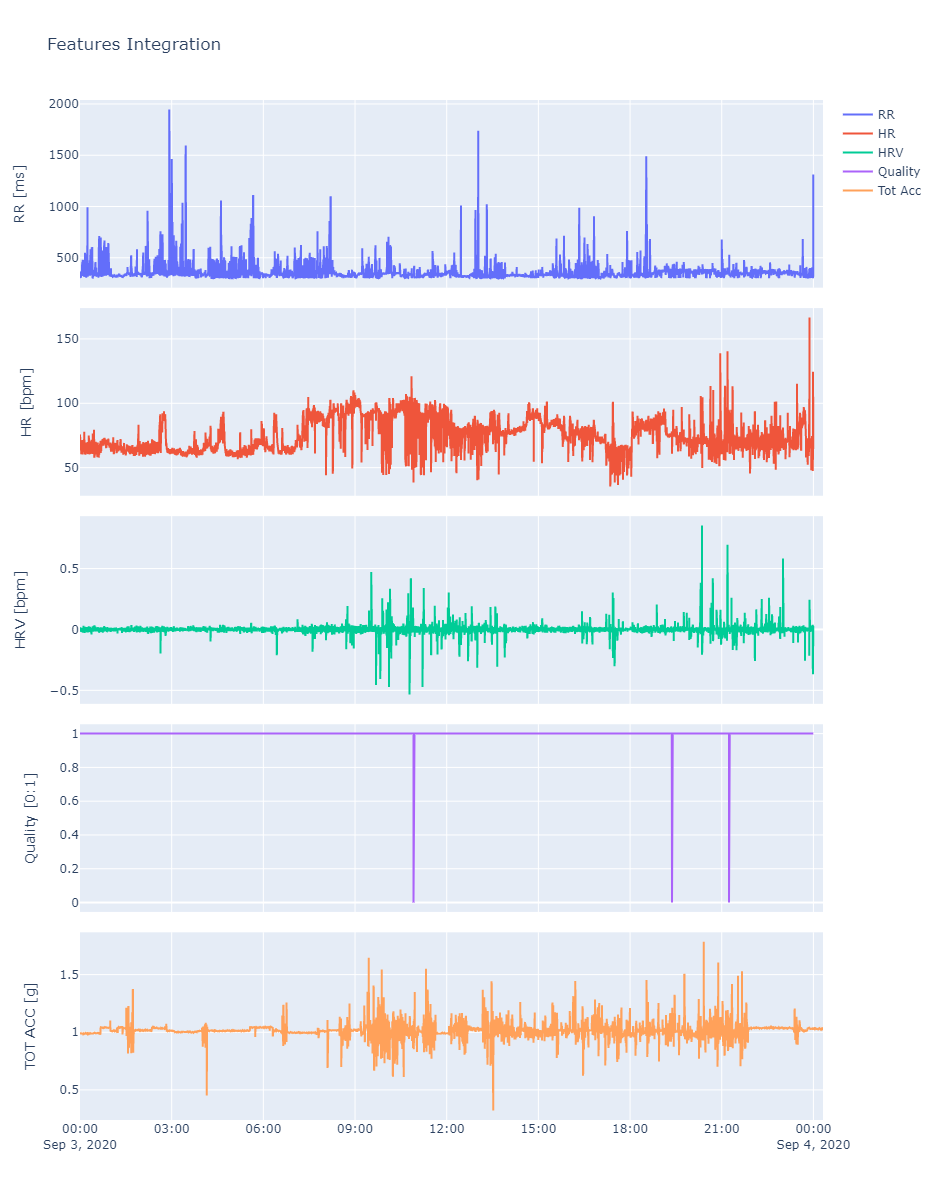

In [15]:
fig = make_subplots(rows=5,vertical_spacing=0.02, shared_xaxes=True)

fig.add_trace(
    go.Scatter(x= dfRRdown['Time'],
               y=dfRRdown['RR'],
    name="RR" ),
    row=1, col=1)
fig['layout']['yaxis']['title']='RR [ms]'

fig.add_trace(
    go.Scatter(x= dfECGdown['Time'],
               y=dfECGdown['HR'],
    name="HR" ),
    row=2, col=1)
fig['layout']['yaxis2']['title']='HR [bpm]'

fig.add_trace(
    go.Scatter(x= dfECGdown['Time'],
               y=dfECGdown['HRV'],
    name="HRV" ),
    row=3, col=1)
fig['layout']['yaxis3']['title']='HRV [bpm]'

fig.add_trace(
    go.Scatter(x= dfECGdown['Time'],
               y=dfECGdown['Quality'],
    name="Quality"),
    row=4, col=1)
fig['layout']['yaxis4']['title']='Quality [0:1]'

fig.add_trace(
    go.Scatter(x= dfACCdown['Time'],
               y=dfACCdown['Tot Acc'],
    name="Tot Acc"),
    row=5, col=1)
fig['layout']['yaxis5']['title']='TOT ACC [g]' 

fig.update_layout(height=1200, width=1000, title_text="Features Integration")
fig.show()